# 导入必要的库

In [1]:
import torch
import random
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
# from d2l import torch as d2l
import matplotlib.pyplot as plt
import pandas as pd
import ast
import numpy as np
torch.set_default_dtype(torch.double)

# 读取训练集、验证集

In [2]:
data = pd.read_csv("../data/water_CNN_with_AlphaEarth_all_merged.csv")


train_data = data[data['random'] <= 0.7]
val_data = data[data['random'] > 0.7]


features = np.array(train_data[['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']].applymap(ast.literal_eval).values.tolist())
features = torch.tensor(features, dtype=torch.double)
labels = torch.tensor(np.array(train_data[['landcover']]), dtype=torch.double)


validation_features = np.array(val_data[['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']].applymap(ast.literal_eval).values.tolist())
validation_features = torch.tensor(validation_features, dtype=torch.double)
validation_labels = torch.tensor(np.array(val_data[['landcover']]), dtype=torch.double)

train_dataset = TensorDataset(features, labels)
validation_dataset = TensorDataset(validation_features, validation_labels)

batch_size = 8
shuffle = True

# 创建 DataLoader
train_iter = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
test_iter = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)  # 在验证集上一般不需要打乱数据

In [8]:
print(conv1_weight.shape, 'conv1_weight')
print(conv1_bias.shape, 'conv1_bias')
print(conv2_weight.shape, 'conv2_weight')
print(conv2_bias.shape, 'conv2_bias')

(16, 11, 3, 3) conv1_weight
(16,) conv1_bias
(32, 16, 3, 3) conv2_weight
(32,) conv2_bias


In [9]:
import numpy as np

# 随机种子以确保可重现性
np.random.seed(42)

# 创建变量函数 - 使用正态分布生成随机权重和偏置
def create_random_weight(shape):
    return np.random.normal(0, 0.1, size=shape)

# 创建所有变量，使用右侧的维度
conv1_bias = create_random_weight((16,))
conv1_weight = create_random_weight((16, 6, 3, 3))
conv2_bias = create_random_weight((32,))
conv2_weight = create_random_weight((32, 16, 3, 3))
conv3_bias = create_random_weight((64,))
conv3_weight = create_random_weight((64, 38, 3, 3))
conv4_bias = create_random_weight((128,))
conv4_weight = create_random_weight((128, 70, 1, 1))
conv5_bias = create_random_weight((1,))
conv5_weight = create_random_weight((1, 128, 1, 1))

# 打印各变量的形状以验证
print("conv1_bias shape:", conv1_bias.shape)
print("conv1_weight shape:", conv1_weight.shape)
print("conv2_bias shape:", conv2_bias.shape)
print("conv2_weight shape:", conv2_weight.shape)
print("conv3_bias shape:", conv3_bias.shape)
print("conv3_weight shape:", conv3_weight.shape)
print("conv4_bias shape:", conv4_bias.shape)
print("conv4_weight shape:", conv4_weight.shape)
print("conv5_bias shape:", conv5_bias.shape)
print("conv5_weight shape:", conv5_weight.shape)

# 可以查看部分值
print("\n部分值示例:")
print("conv1_bias[0:5]:", conv1_bias[0:5])
print("conv1_weight[0,0,0]:", conv1_weight[0,0,0])

conv1_bias shape: (16,)
conv1_weight shape: (16, 6, 3, 3)
conv2_bias shape: (32,)
conv2_weight shape: (32, 16, 3, 3)
conv3_bias shape: (64,)
conv3_weight shape: (64, 38, 3, 3)
conv4_bias shape: (128,)
conv4_weight shape: (128, 70, 1, 1)
conv5_bias shape: (1,)
conv5_weight shape: (1, 128, 1, 1)

部分值示例:
conv1_bias[0:5]: [ 0.04967142 -0.01382643  0.06476885  0.15230299 -0.02341534]
conv1_weight[0,0,0]: [-0.10128311  0.03142473 -0.09080241]


In [24]:
# 使用自定义函数对数组进行舍入并转换为列表
def round_array(arr, decimals=3):
    """对嵌套数组进行舍入，保留指定小数位数"""
    if isinstance(arr, np.ndarray):
        return [round_array(x, decimals) for x in arr]
    else:
        return round(float(arr), decimals)

# 对数组进行舍入处理
rounded_weight = round_array(conv3_weight)

# 方法1：使用repr并替换所有换行符
one_line_str = repr(rounded_weight).replace('\n', '')
print(one_line_str)

[[[[0.117, -0.072, -0.064], [-0.274, 0.119, 0.154], [-0.055, -0.025, -0.075]], [[0.038, 0.112, -0.174], [0.041, -0.028, 0.011], [0.046, -0.019, -0.01]], [[-0.021, 0.097, 0.042], [0.022, -0.127, -0.038], [0.09, 0.004, 0.066]], [[0.177, 0.104, 0.009], [-0.051, -0.255, -0.017], [-0.033, 0.039, -0.015]], [[-0.032, -0.178, -0.094], [0.048, 0.172, -0.01], [0.033, 0.095, -0.081]], [[0.037, -0.074, 0.086], [0.015, 0.03, -0.078], [0.071, 0.208, -0.101]], [[-0.034, 0.023, 0.079], [-0.056, -0.283, 0.136], [0.076, -0.174, -0.061]], [[0.157, 0.145, 0.094], [-0.018, 0.008, -0.013], [0.113, -0.088, -0.081]], [[0.101, -0.004, 0.138], [-0.067, -0.005, -0.092], [0.001, -0.148, -0.049]], [[-0.144, 0.069, 0.072], [-0.173, 0.133, 0.25], [0.005, -0.064, 0.282]], [[-0.132, 0.002, 0.018], [0.135, 0.036, -0.05], [-0.095, -0.034, -0.101]], [[0.005, -0.056, -0.149], [0.126, -0.05, -0.127], [-0.017, 0.007, -0.175]], [[0.033, -0.105, 0.171], [0.052, -0.04, -0.075], [-0.01, 0.061, -0.003]], [[-0.022, 0.006, -0.06],

In [26]:
import numpy as np
import json

# 随机种子以确保可重现性
np.random.seed(42)

# 创建变量函数 - 使用正态分布生成随机权重和偏置
def create_random_weight(shape):
    return np.random.normal(0, 0.1, size=shape)

# 创建所有变量，使用指定的维度
conv1_bias = create_random_weight((16,))
conv1_weight = create_random_weight((16, 6, 3, 3))
conv2_bias = create_random_weight((32,))
conv2_weight = create_random_weight((32, 16, 3, 3))
conv3_bias = create_random_weight((64,))
conv3_weight = create_random_weight((64, 38, 3, 3))
conv4_bias = create_random_weight((128,))
conv4_weight = create_random_weight((128, 70, 1, 1))
conv5_bias = create_random_weight((1,))
conv5_weight = create_random_weight((1, 128, 1, 1))

# 使用自定义函数对数组进行舍入并转换为列表
def round_array(arr, decimals=3):
    """对嵌套数组进行舍入，保留指定小数位数"""
    if isinstance(arr, np.ndarray):
        return [round_array(x, decimals) for x in arr]
    else:
        return round(float(arr), decimals)

# 打开文件用于写入
with open('E:/OneDrive/work/2025-yuchao/data/model_parameters.txt', 'w') as f:
    # 存储所有参数的字典
    all_params = {
        'conv1_bias': conv1_bias,
        'conv1_weight': conv1_weight,
        'conv2_bias': conv2_bias,
        'conv2_weight': conv2_weight,
        'conv3_bias': conv3_bias,
        'conv3_weight': conv3_weight,
        'conv4_bias': conv4_bias,
        'conv4_weight': conv4_weight,
        'conv5_bias': conv5_bias,
        'conv5_weight': conv5_weight
    }
    
    # 遍历并写入每个参数
    for name, param in all_params.items():
        # 写入参数名称和形状
        f.write(f"{name} shape: {param.shape}\n")
        
        # 对数组进行舍入处理
        rounded_param = round_array(param)
        
        # 将舍入后的参数转换为单行字符串并写入
        one_line_str = repr(rounded_param).replace('\n', '')
        f.write(f"{name} = {one_line_str}\n\n")

print("所有参数已保存到 model_parameters.txt 文件")

# 另外，如果你还想在控制台查看特定参数，例如conv3_weight
rounded_conv3_weight = round_array(conv3_weight)
one_line_str = repr(rounded_conv3_weight).replace('\n', '')
print(f"conv3_weight = {one_line_str}")

所有参数已保存到 model_parameters.txt 文件
conv3_weight = [[[[0.117, -0.072, -0.064], [-0.274, 0.119, 0.154], [-0.055, -0.025, -0.075]], [[0.038, 0.112, -0.174], [0.041, -0.028, 0.011], [0.046, -0.019, -0.01]], [[-0.021, 0.097, 0.042], [0.022, -0.127, -0.038], [0.09, 0.004, 0.066]], [[0.177, 0.104, 0.009], [-0.051, -0.255, -0.017], [-0.033, 0.039, -0.015]], [[-0.032, -0.178, -0.094], [0.048, 0.172, -0.01], [0.033, 0.095, -0.081]], [[0.037, -0.074, 0.086], [0.015, 0.03, -0.078], [0.071, 0.208, -0.101]], [[-0.034, 0.023, 0.079], [-0.056, -0.283, 0.136], [0.076, -0.174, -0.061]], [[0.157, 0.145, 0.094], [-0.018, 0.008, -0.013], [0.113, -0.088, -0.081]], [[0.101, -0.004, 0.138], [-0.067, -0.005, -0.092], [0.001, -0.148, -0.049]], [[-0.144, 0.069, 0.072], [-0.173, 0.133, 0.25], [0.005, -0.064, 0.282]], [[-0.132, 0.002, 0.018], [0.135, 0.036, -0.05], [-0.095, -0.034, -0.101]], [[0.005, -0.056, -0.149], [0.126, -0.05, -0.127], [-0.017, 0.007, -0.175]], [[0.033, -0.105, 0.171], [0.052, -0.04, -0.075], [

<!-- # 随机生成数据进行测试

num_samples = 2000
input_shape = (10, 7, 7)
features = torch.randn(num_samples, *input_shape)
labels = torch.randint(0, 2, (num_samples, 1))

num_validation_samples = 400
validation_features = torch.randn(num_validation_samples, *input_shape)
validation_labels  = torch.randint(0, 2, (num_validation_samples, 1))

train_dataset = TensorDataset(features, labels)
validation_dataset = TensorDataset(validation_features, validation_labels)

batch_size = 200
shuffle = True

# 创建 DataLoader
train_iter = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
test_iter = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)  # 在验证集上一般不需要打乱数据 -->

# 构建模型

In [2]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0)
        self.conv3 = nn.Conv2d(in_channels=42, out_channels=64, kernel_size=(3, 3))
        self.conv4 = nn.Conv2d(in_channels=74, out_channels=128, kernel_size=(1, 1))
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=2, kernel_size=(1, 1))

    def forward(self, x):
        x1 = F.relu(self.conv1(x))  # 16，5, 5, 
        x2 = F.relu(self.conv2(x1))  # 32, 3, 3
        center_3x3 = x[:, :, 2:5, 2:5]
        x3 = F.relu(self.conv3(torch.cat((x2, center_3x3), dim=1)))  # 64, 1, 1
        center_1x1 = x[:, :, 3:-3, 3:-3]
        x4 = F.relu(self.conv4(torch.cat((x3, center_1x1), dim=1)))  # 128, 1, 1
        x5 = self.conv5(x4)  # 1, 1, 2
        return x5

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(reduction='mean')

# 训练及验证

In [5]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [7]:
num_epochs = 180
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0  
    for inputs, labels in train_iter:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.view(-1, 2), labels.view(-1).long())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (torch.argmax(outputs, dim=1).view(-1) == labels.view(-1)).sum().item()
        total_samples += labels.size(0)
   
    # 在验证集上进行验证
    model.eval()
    with torch.no_grad():
        total_val_loss = 0
        total_val_correct = 0
        num_validation_samples = 0
        for inputs, labels in test_iter:
            inputs = inputs.to(device)
            labels = labels.to(device)
            val_outputs = model(inputs)
            val_loss = criterion(val_outputs.view(-1, 2), labels.view(-1).long())
            total_val_loss += val_loss.item()
            total_val_correct += (torch.argmax(val_outputs, dim=1).view(-1) == labels.view(-1)).sum().item()
            num_validation_samples += labels.size(0)

        val_accuracy = total_val_correct / num_validation_samples
        
    # 计算平均损失值和准确率
    avg_loss = total_loss / len(train_iter)
    avg_val_loss = total_val_loss / len(test_iter)
    train_accuracy = total_correct / total_samples
    
    # 将每个epoch的训练和验证集的loss和准确率数据添加到列表中
    train_losses.append(avg_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Epoch 1/180, Train Loss: 0.6846, Validation Loss: 0.6732, Train Accuracy: 0.6596, Validation Accuracy: 0.7345
Epoch 2/180, Train Loss: 0.6593, Validation Loss: 0.6522, Train Accuracy: 0.7394, Validation Accuracy: 0.7345
Epoch 3/180, Train Loss: 0.6382, Validation Loss: 0.6352, Train Accuracy: 0.7394, Validation Accuracy: 0.7345
Epoch 4/180, Train Loss: 0.6212, Validation Loss: 0.6213, Train Accuracy: 0.7394, Validation Accuracy: 0.7345
Epoch 5/180, Train Loss: 0.6095, Validation Loss: 0.6103, Train Accuracy: 0.7394, Validation Accuracy: 0.7345
Epoch 6/180, Train Loss: 0.5987, Validation Loss: 0.6013, Train Accuracy: 0.7394, Validation Accuracy: 0.7345
Epoch 7/180, Train Loss: 0.5886, Validation Loss: 0.5938, Train Accuracy: 0.7394, Validation Accuracy: 0.7345
Epoch 8/180, Train Loss: 0.5784, Validation Loss: 0.5875, Train Accuracy: 0.7394, Validation Accuracy: 0.7345
Epoch 9/180, Train Loss: 0.5761, Validation Loss: 0.5826, Train Accuracy: 0.7394, Validation Accuracy: 0.7345
Epoch 10/1

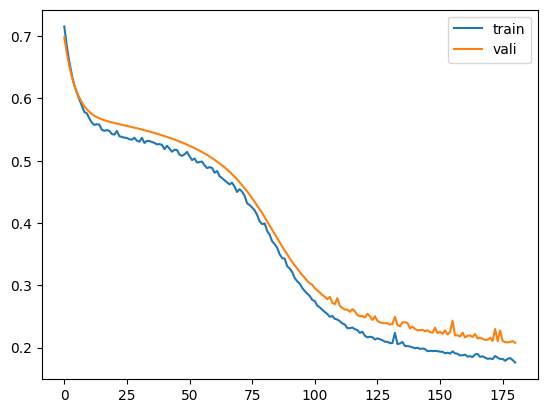

In [8]:
import os
import matplotlib.pyplot as plt
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
plt.plot(train_losses, label='train')
plt.plot(val_losses, label = 'vali')
plt.legend()

In [9]:
# 保存模型
torch.save(model.state_dict(), 'geeCNN_waterModel.pth')

In [3]:
path_trained_model = 'geeCNN_waterModel.pth'
model = CNN()
model.load_state_dict(torch.load(path_trained_model))
model.eval()

weights_and_biases = {}

for layer_name, params in model.named_parameters():
    weights_and_biases[layer_name] = params.detach().numpy().tolist()

FileNotFoundError: [Errno 2] No such file or directory: 'geeCNN_waterModel.pth'

In [11]:
weights_and_biases.keys()

dict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'conv3.weight', 'conv3.bias', 'conv4.weight', 'conv4.bias', 'conv5.weight', 'conv5.bias'])

In [23]:
print(weights_and_biases['conv1.bias'])

[-0.03377825931041718, 0.01523923098570193, -0.11128176474183818, 0.01859251424605187, -0.0781082479059054, 0.10800000949470767, 0.09655499953859265, 0.030507271087307684, -0.09255274821246183, 0.12707936928077482, -0.013718877771113894, -0.05601650343876771, 0.1629509388156359, 0.02846634118037243, -0.03780252048046039, 0.050596170864213794]
